<a href="https://colab.research.google.com/github/rahiakela/practical-machine-learning-with-tensorflow/blob/week-5/assignment_5_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning Using Pretrained ConvNets

You will follow the general machine learning workflow.

* 1 Examine and understand the data
* 2 Build an input pipeline
* 3 Compose our model
  * Part-1: Load in our pretrained base model (and pretrained weights)
  * Part-2: Stack our classification layers on top
* 4 Train our model
* 5 Evaluate model

## Import and Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import numpy as np

import matplotlib.pyplot as plt

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

keras = tf.keras

TensorFlow 2.x selected.


## Data preprocessing

In [0]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [20]:
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)
(raw_train, raw_validation, raw_test), metadata = tfds.load(name="tf_flowers", 
                                                            with_info=True,
                                                            split=list(splits),                                         
                                                            as_supervised=True)

print(raw_train)
print(raw_validation)
print(raw_test)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


Show the first two images and labels from the training set:

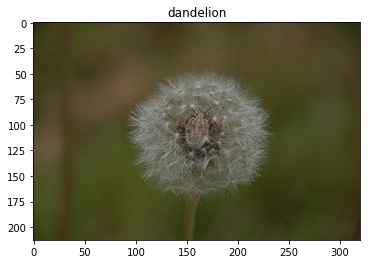

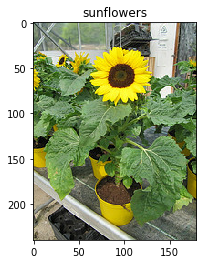

In [21]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

### Format the Data

In [0]:
IMG_SIZE = 160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/255)
  print('Before resizing: ', image.shape)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  print('Afetr resizing: ', image.shape)
  return image, label

Apply this function to each item in the dataset using the map method:

In [23]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

print('Training set shape: ', train.batch)
print('Vaidation set shape: ', validation.batch)
print('Testing set shape: ', test.batch)

Before resizing:  (None, None, 3)
Afetr resizing:  (160, 160, 3)
Before resizing:  (None, None, 3)
Afetr resizing:  (160, 160, 3)
Before resizing:  (None, None, 3)
Afetr resizing:  (160, 160, 3)
Training set shape:  <bound method DatasetV2.batch of <MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>>
Vaidation set shape:  <bound method DatasetV2.batch of <MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>>
Testing set shape:  <bound method DatasetV2.batch of <MapDataset shapes: ((160, 160, 3), ()), types: (tf.float32, tf.int64)>>


Now shuffle and batch the data.

In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [0]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

#### Q5 What is the shape of one batch of data?

In [26]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 160, 160, 3])

## 1. Create the base model from the pre-trained convnets

You will create the base model from the Inception V3 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset of 1.4M images and 1000 classes of web images. This model has already learned the basic features that are common in 1000 objects that we see daily. Hence, it has a strong feature extraction capability. We download a network that doesn’t include the classification layers at the top, by specifying include_top=False argument, because we only want to use the feature extraction portion of these pre-trained convnets (convolutional base)

In [0]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model Inception V3
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

### Q6 What is the shape of a new block of features converted by the feature extractor?

In [29]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 2048)


In [30]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 79, 79, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 79, 79, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 79, 79, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

## Feature extraction

### Freeze the convolutional base

In [0]:
base_model.trainable = False

### Add a classification head

In [32]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [33]:
prediction_layer = keras.layers.Dense(metadata.features['label'].num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


Now stack the feature extractor, and these two layers using a tf.keras.Sequential model:

In [0]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer                    
])

### Q7 What is the total number trainable TF variables in the model?

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 10,245
Non-trainable params: 21,802,784
_________________________________________________________________
